# [ LG에너지솔루션 DX Expert 양성과정 ]

## 시계열 데이터 분석을 위한 딥러닝

### 강의 복습
강의자료 : 시계열 데이터 분석을 위한 딥러닝

- `Classification`: 특정 기간(제품 가공 기간) 데이터를 입력으로 하고 특정 범주를 출력으로 하는 분류 모델 (제품의 양/불 판정 등)
- `Transformer`: Transformer는 Sequence를 입력으로 받아 sequenc를 출력하는 구조이므로, 시계열 과업에도 적용 가능
- `Representation learning` : 시계열의 의미 있는 정보를 더 쉽게 추출할 수 있도록 고차원의 raw data를 저 차원 공간에 mapping하는 것을 목표, 비지도 학습 방식으로 해당 데이터의 representation을 학습하고, 이를 downstreamtask에서 활용하는 방식

<img src="https://github.com/hwk0702/2024_LG_ES_External_Lecture/blob/main/240709_DL4TS/image/CLS01.png?raw=true" width="800">

### 실습 요약

1. 본 실습에서는 Transformer를 활용한 representation learning 모델인 TS2Vec을 활용하여 시계열 분류를 수행합니다.
2. Unlabeled data로 부터 Positive / Negative pair를 구축하여 contrastive learning을 통해 pre-training을 수행합니다.
3. 분류 과업을 수행하도록 fine-tuning을 진행합니다.

[Yue, Zhihan, et al. "Ts2vec: Towards universal representation of time series." Proceedings of the AAAI Conference on Artificial Intelligence. Vol. 36. No. 8. 2022.](https://ojs.aaai.org/index.php/AAAI/article/view/20881)

<img src="https://github.com/hwk0702/2024_LG_ES_External_Lecture/blob/main/240703_Transformer/image/ts2vec01.png?raw=true" width="600">

---

### STEP 0. 환경 구축하기

- 필요한 library들을 import 합니다.

In [1]:
# github에서 데이터 불러오기
# !git clone https://github.com/yuezhihan/ts2vec.git
%cd ./ts2vec

/dsba/External_Lecture/2024/2024_LG_ES_External_Lecture/240709_DL4TS/ts2vec


/opt/conda/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [ ]:
!pip install bottleneck

In [2]:
import os
import sys
from urllib import request
import time
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import timedelta
import dateutil
import math
from sklearn.preprocessing import MinMaxScaler, StandardScaler, label_binarize  # 데이터 전처리를 위한 스케일링 모듈
from sklearn.metrics import average_precision_score
from sklearn.model_selection import train_test_split

import torch
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torch.nn as nn

from models import TSEncoder
from models.losses import hierarchical_contrastive_loss
from utils import init_dl_program, name_with_datetime, pkl_save, data_dropout
from utils import take_per_row, split_with_nan, centerize_vary_length_series, torch_pad_nan
from tasks import _eval_protocols as eval_protocols

import warnings
warnings.filterwarnings("ignore")

#check torch version & device
print ("Python version:[%s]."%(sys.version))
print ("PyTorch version:[%s]."%(torch.__version__))
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device = init_dl_program(1, seed=42, max_threads=None)
print ("device:[%s]."%(device)) # device에 cuda:0가 프린트 된다면 GPU를 사용하는 상태입니다

Python version:[3.10.14 (main, May  6 2024, 19:42:50) [GCC 11.2.0]].
PyTorch version:[2.3.1+cu121].
device:[cuda:1].


In [3]:
# set random seed 
def set_seed(random_seed):
    torch.manual_seed(random_seed)
    torch.cuda.manual_seed(random_seed)
    torch.cuda.manual_seed_all(random_seed)  # if use multi-GPU
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(random_seed)
    random.seed(random_seed)
    
random_seed = 42
set_seed(random_seed)

In [4]:
class Config:
    # dataset 관련 parameters
    datadir = '../data'
    
    # model 관련 paremeters
    output_dims = 64
    hidden_dims = 64
    depth = 3
    
    # training 관련 parameters
    epochs = 100
    batch_size = 256
    test_batch_size = 256
    learning_rate = 0.001
    num_workers = 2
    log_interval = 2000

    # device
    device = 'cuda'

    # seed
    seed = 223

cfg = Config()

### STEP 1. 데이터 준비하기
이번 실습에서는 ECG Heartbeat Categorization 데이터를 활용하여 시계열 분류를 진행합니다.

- MIT-BIH 부정맥 데이터셋과 PTB 진단 심전도 데이터베이스에서 파생된 두 개의 심장 박동 신호 컬렉션으로 구성되어 있음
- 실습에서는 MIT-BIH 부정맥 데이터셋 사용
- 정상적인 경우와 다양한 부정맥 및 심근경색의 영향을 받은 경우의 심전도(ECG) 형태의 심장 박동을 제공
- 데이터셋 출처
    - https://www.kaggle.com/datasets/shayanfazeli/heartbeat/data

| Name       | Description                             |
|-------------------|-----------------------------------------|
| Number of Samples | 109446 |
| Number of Categories | 5 |
| Sampling Frequency | 125Hz |
| Data Source | Physionet's MIT-BIH Arrhythmia Dataset |
| Classes | ['N': 0, 'S': 1, 'V': 2, 'F': 3, 'Q': 4] |

In [5]:
# !pip install gdown
# import gdown
!mkdir ../data

train_url1 = 'https://drive.google.com/uc?id=1iomPOwLtgQFSdeYaAgNL8mo05nrLz7V4'
train_file1 = '../data/mitbih_train1.csv'  
gdown.download(train_url1, train_file1, quiet=False)

train_url2 = 'https://drive.google.com/uc?id=10WPBh1zIXFQP2oWmLpz8XPtzKj2VCtdu'
train_file2 = '../data/mitbih_train2.csv'  
gdown.download(train_url2, train_file2, quiet=False)

train_url3 = 'https://drive.google.com/uc?id=1E7a737hYLl6JO-0Wi3BMSf_DyMUVZY_Y'
train_file3 = '../data/mitbih_train3.csv'  
gdown.download(train_url3, train_file3, quiet=False)

test_url = 'https://drive.google.com/uc?id=1dGblyAqCgfCjRp5ZK6JVX7geYlMx52e1'
test_file = '../data/mitbih_test.csv'  
gdown.download(test_url, test_file, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1iomPOwLtgQFSdeYaAgNL8mo05nrLz7V4
To: /dsba/External_Lecture/2024/2024_LG_ES_External_Lecture/240709_DL4TS/data/mitbih_train1.csv
100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 70.7M/70.7M [00:01<00:00, 40.3MB/s]
Downloading...
From: https://drive.google.com/uc?id=10WPBh1zIXFQP2oWmLpz8XPtzKj2VCtdu
To: /dsba/External_Lecture/2024/2024_LG_ES_External_Lecture/240709_DL4TS/data/mitbih_train2.csv
100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 70.8M/70.8M [00:01<00:00, 38.1MB/s]
Downloading...
From: https://drive.google.com/uc?id=1E7a737hYLl6JO-0Wi3BMSf_DyMUVZY_Y
To: /dsba/External_Lecture/2024/2024_LG_ES_External_Lecture/240709_DL4TS/data/mitbih_train3.csv
100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 71.6M/71.6M [00:01<00:00, 42.5MB/s]
Downloading...
From: http

'../data/mitbih_test.csv'

In [6]:
df1 = pd.read_csv('../data/mitbih_train1.csv')
df2 = pd.read_csv('../data/mitbih_train2.csv')
df3 = pd.read_csv('../data/mitbih_train3.csv')

# 세 데이터프레임을 하나로 결합
train_df = pd.concat([df1, df2, df3], ignore_index=True)
train_df.columns = [int(col) for col in train_df.columns]
test_df = pd.read_csv('../data/mitbih_test.csv',header=None)

In [7]:
train_df

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
0,0.977941,0.926471,0.681373,0.245098,0.154412,0.191176,0.151961,0.085784,0.058824,0.049020,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.960114,0.863248,0.461538,0.196581,0.094017,0.125356,0.099715,0.088319,0.074074,0.082621,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.000000,0.659459,0.186486,0.070270,0.070270,0.059459,0.056757,0.043243,0.054054,0.045946,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.925414,0.665746,0.541436,0.276243,0.196133,0.077348,0.071823,0.060773,0.066298,0.058011,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.967136,1.000000,0.830986,0.586854,0.356808,0.248826,0.145540,0.089202,0.117371,0.150235,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87549,0.807018,0.494737,0.536842,0.529825,0.491228,0.484211,0.456140,0.396491,0.284211,0.136842,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
87550,0.718333,0.605000,0.486667,0.361667,0.231667,0.120000,0.051667,0.001667,0.000000,0.013333,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
87551,0.906122,0.624490,0.595918,0.575510,0.530612,0.481633,0.444898,0.387755,0.322449,0.191837,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
87552,0.858228,0.645570,0.845570,0.248101,0.167089,0.131646,0.121519,0.121519,0.118987,0.103797,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0


In [8]:
test_df

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
0,1.000000,0.758264,0.111570,0.000000,0.080579,0.078512,0.066116,0.049587,0.047521,0.035124,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.908425,0.783883,0.531136,0.362637,0.366300,0.344322,0.333333,0.307692,0.296703,0.300366,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.730088,0.212389,0.000000,0.119469,0.101770,0.101770,0.110619,0.123894,0.115044,0.132743,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.000000,0.910417,0.681250,0.472917,0.229167,0.068750,0.000000,0.004167,0.014583,0.054167,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.570470,0.399329,0.238255,0.147651,0.000000,0.003356,0.040268,0.080537,0.070470,0.090604,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21887,0.928736,0.871264,0.804598,0.742529,0.650575,0.535632,0.394253,0.250575,0.140230,0.102299,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
21888,0.802691,0.692078,0.587444,0.446936,0.318386,0.189836,0.118087,0.077728,0.112108,0.152466,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
21889,1.000000,0.967359,0.620178,0.347181,0.139466,0.089021,0.103858,0.100890,0.106825,0.100890,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
21890,0.984127,0.567460,0.607143,0.583333,0.607143,0.575397,0.575397,0.488095,0.392857,0.238095,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0


In [9]:
# 마지막 열이 target
target_column_index = train_df.shape[1] - 1

# target 고유 값 가져오기
class_labels = train_df[target_column_index].unique()

# 도메인 지식을 기반으로 클래스 레이블의 이름 지정
class_names = {
    0: "Normal Beats",
    1: "Supraventricular Ectopy Beats",
    2: "Ventricular Ectopy Beats",
    3: "Fusion Beats",
    4: "Unclassifiable Beats"
}

for label in class_labels:
    print(f"Class label {int(label)}: {class_names[label]}")

Class label 0: Normal Beats
Class label 1: Supraventricular Ectopy Beats
Class label 2: Ventricular Ectopy Beats
Class label 3: Fusion Beats
Class label 4: Unclassifiable Beats


### STEP 2. 데이터 EDA 

In [10]:
train_df[target_column_index] = train_df[target_column_index].astype(int)
test_df[target_column_index] = test_df[target_column_index].astype(int)
train_value_counts = train_df[target_column_index].value_counts().sort_index()
test_value_counts = test_df[target_column_index].value_counts().sort_index()

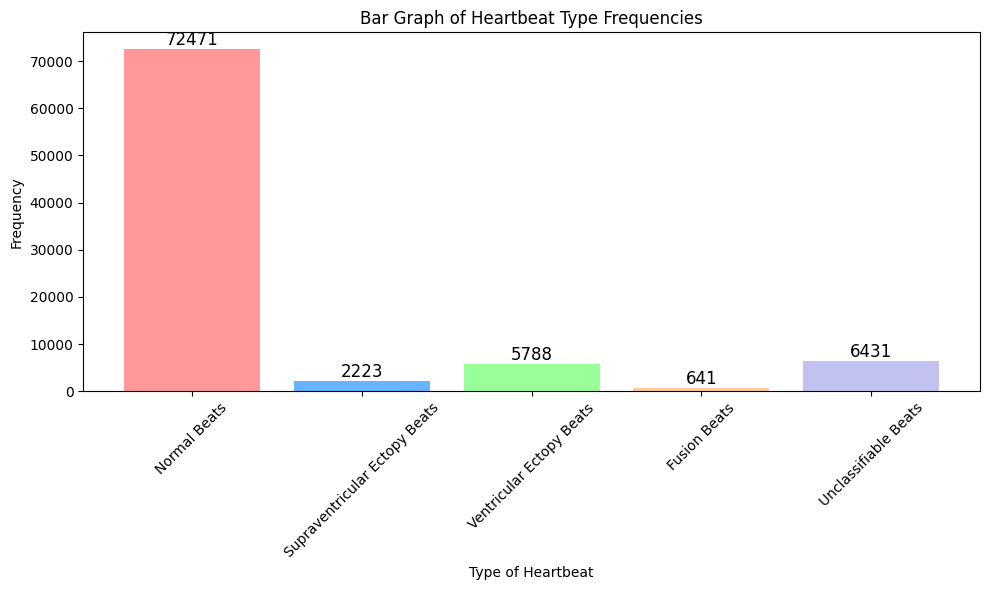

In [11]:
train_value_counts.index = train_value_counts.index.map(class_names)


colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99', '#c2c2f0']
fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(train_value_counts.index, train_value_counts.values, color=colors)

# 각 바 위에 수치 표시
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, int(yval), va='bottom', ha='center', fontsize=12)

plt.xlabel('Type of Heartbeat')
plt.ylabel('Frequency')
plt.title('Bar Graph of Heartbeat Type Frequencies')
plt.xticks(rotation=45)  # 레이블 회전
plt.tight_layout()  # 레이블이 잘리지 않도록 조정
plt.show()

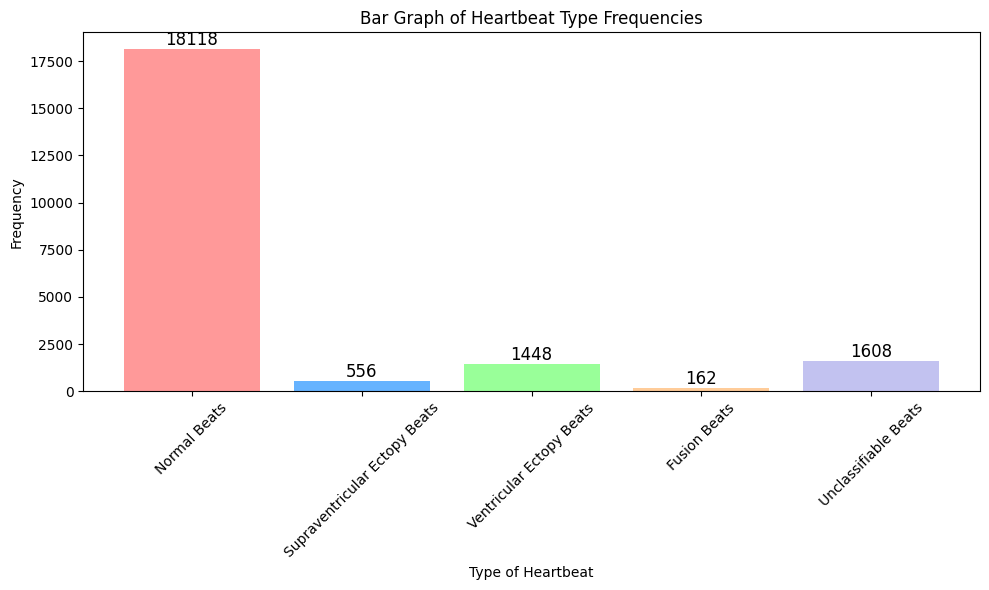

In [12]:
test_value_counts.index = test_value_counts.index.map(class_names)


colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99', '#c2c2f0']
fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(test_value_counts.index, test_value_counts.values, color=colors)

# 각 바 위에 수치 표시
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, int(yval), va='bottom', ha='center', fontsize=12)

plt.xlabel('Type of Heartbeat')
plt.ylabel('Frequency')
plt.title('Bar Graph of Heartbeat Type Frequencies')
plt.xticks(rotation=45)  # 레이블 회전
plt.tight_layout()  # 레이블이 잘리지 않도록 조정
plt.show()

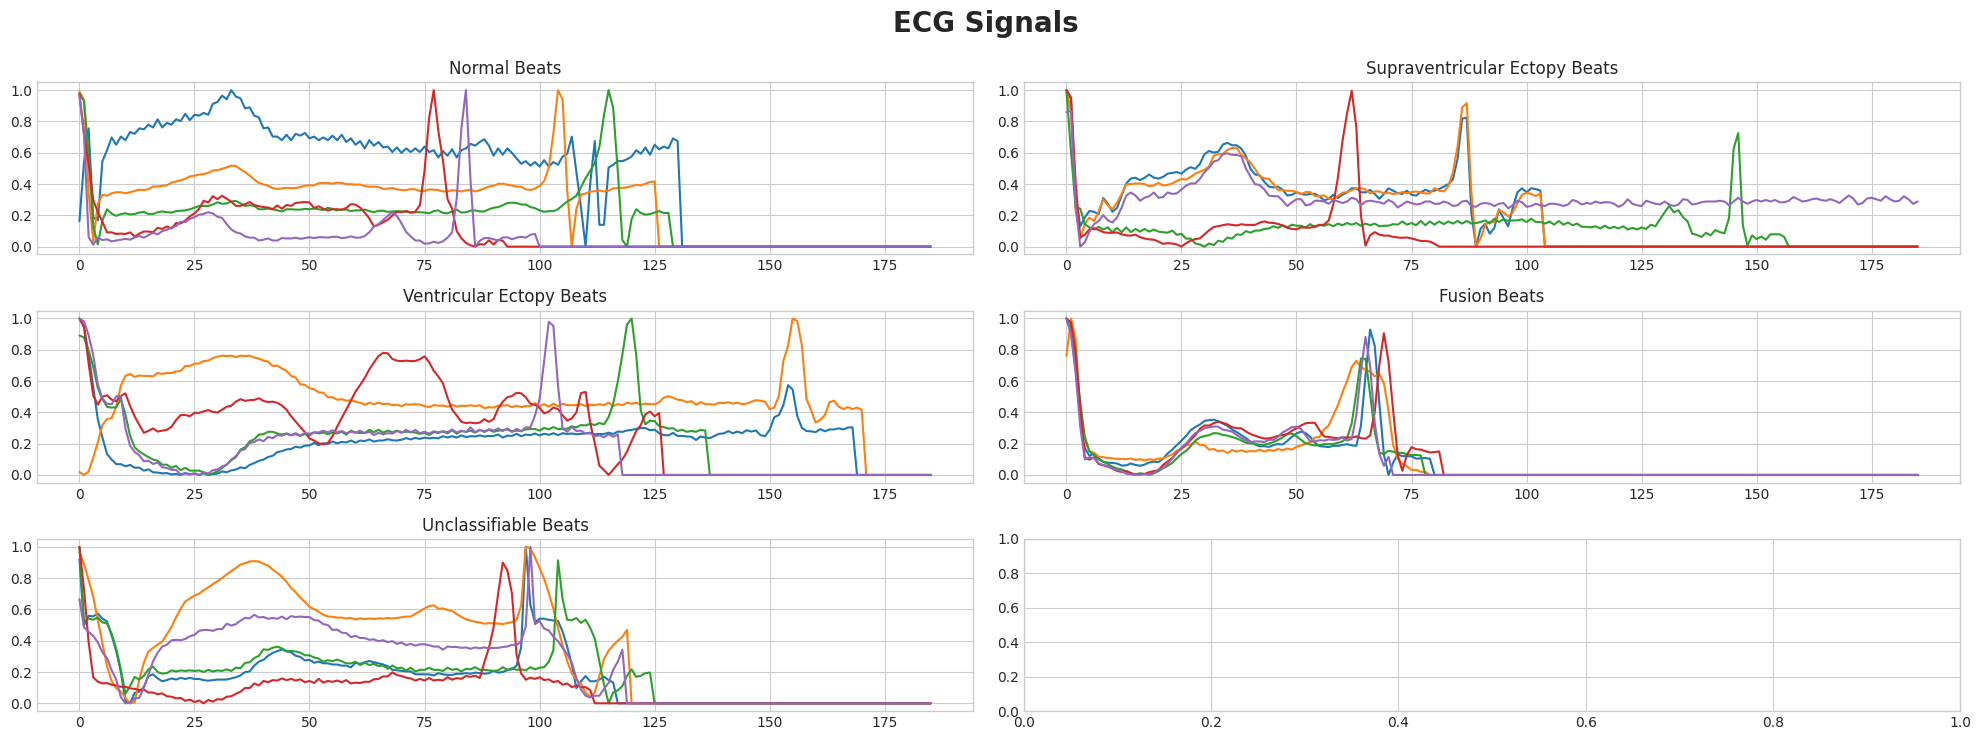

In [13]:
N = 5
samples = [train_df.loc[train_df[target_column_index] == cls].sample(N) for cls in range(N)]
titles = [class_names[cls] for cls in range(5)]

with plt.style.context("seaborn-v0_8-whitegrid"):
    fig, axs = plt.subplots(3, 2, figsize=(20, 7))
    for i in range(5):
        ax = axs.flat[i]
        ax.plot(samples[i].values[:,:-2].transpose())
        ax.set_title(titles[i])
        #plt.ylabel("Amplitude")

    plt.tight_layout()
    plt.suptitle("ECG Signals", fontsize=20, y=1.05, weight="bold")
plt.show()

### STEP 3. 데이터 전처리 및 loader 생성 

In [14]:
X_train = train_df.drop(columns = [target_column_index])
y_train = train_df[target_column_index]

In [15]:
# Split the training data into training and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

# Separate features and target variable for test dataset
X_test = test_df.drop(columns=[187])
y_test = test_df[187]

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit the scaler to the training data and transform it
X_train_normalized = scaler.fit_transform(X_train)
# Transform the valid data using the fitted scaler
X_valid_normalized = scaler.transform(X_valid)
# Transform the test data using the fitted scaler
X_test_normalized = scaler.transform(X_test)

print("Before Normalization:")
print(X_train.head(5))

print("After Normalization:")
print(X_train_normalized[:, 5])

Before Normalization:
            0         1         2         3         4         5         6    \
14872  0.053191  0.162234  0.292553  0.441489  0.521277  0.627660  0.747340   
50486  0.974265  0.867647  0.591912  0.312500  0.128676  0.022059  0.000000   
84864  0.752322  0.637771  0.540248  0.411765  0.272446  0.151703  0.086687   
71041  0.977654  0.916201  0.614525  0.364991  0.327747  0.294227  0.240223   
78758  0.015464  0.000000  0.033505  0.108247  0.203608  0.269330  0.349227   

            7         8         9    ...  177  178  179  180  181  182  183  \
14872  0.784574  0.779255  0.795213  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
50486  0.014706  0.044118  0.055147  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
84864  0.023220  0.024768  0.043344  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
71041  0.210428  0.178771  0.152700  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
78758  0.444588  0.511598  0.600515  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

       184  185  186  
14872

In [16]:
class ECGDataset(Dataset):

    def __init__(self, X, Y):
        self.signals = X
        self.targets = np.array(Y)

    def __getitem__(self, idx):
        signal = self.signals[idx]
        signal = torch.FloatTensor(signal) 
        signal = torch.unsqueeze(signal, 1)
        target = torch.tensor(self.targets[idx])
        return signal, target

    def __len__(self):
        return len(self.signals)

In [17]:
train_dataset = ECGDataset(X_train_normalized, y_train)
valid_dataset = ECGDataset(X_valid_normalized, y_valid)
test_dataset = ECGDataset(X_test_normalized, y_test)

In [30]:
batch_size = 128
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, drop_last=False)
valid_loader = DataLoader(dataset=valid_dataset, batch_size=batch_size, drop_last=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, drop_last=False)

In [19]:
inputs, targets = next(iter(train_loader))
print('inputs.shape: ', inputs.shape)
print('targets: ', targets)

inputs.shape:  torch.Size([128, 187, 1])
targets:  tensor([0, 0, 4, 0, 2, 1, 0, 0, 0, 2, 0, 2, 0, 0, 0, 2, 4, 0, 0, 0, 0, 0, 0, 0,
        2, 0, 0, 0, 4, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 4, 2, 0, 0, 0, 0, 0, 0,
        0, 0, 3, 0, 2, 0, 0, 0, 4, 0, 4, 0, 0, 0, 0, 1, 0, 4, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 4, 2, 0, 0,
        0, 0, 0, 0, 4, 4, 0, 0, 0, 0, 0, 3, 0, 0, 2, 0, 0, 0, 0, 4, 2, 0, 2, 0,
        0, 0, 0, 0, 0, 0, 0, 0])


### STEP 4. 모델 (TS2Vec)
- 어떠한 granularity에도 강건한 representation 
    - Multiple resolution의 contextual information 포착하여 모든 semantic level을 기반으로 representation 생성
    - Hierarchical contrasting 구조로 어떠한 granularity의 데이터에 대해서라도 fine-grained representation 생성
- 시계열 데이터의 특성에 적합한 augmentation 기법
    - Transformation-invariance, cropping-invariance 가정의 도입 없이도 강건한 contextual representation을 학습할 수 있는 새로운 augmentation 방법론을 제안
- Task에 agnostic한 representation
    - Classification, forecasting task에 대해 무수히 많은 데이터셋을 기반으로 실험을 진행하고 효과를 입증

지난 실습에서 전처리한 데이터셋을 불러옵니다.

SWaT 데이터를 활용하여 시계열 이상탐지를 진행합니다.
* 스마트 물 처리 공장 내의 센서 및 액추에이터 데이터로, 펌프와 밸브 등의 작동 상태를 바탕으로 추출된 물의 흐름, 압력, 수위 등 다양한 물리적 변수 포함
* 11일 간 51개 센서에서 수집된 데이터셋이며, 다양한 사이버 공격 시나리오가 포함됨. 이상치는 전체 11일 기간 중 마지막 4일에서 총 41회 발생
* 데이터 크기 및 유형: 11일간의 연속 데이터, 946,722개의 데이터 포인트, 이상 비율 11.98%
* 데이터셋 출처
    * https://itrust.sutd.edu.sg/itrust-labs_datasets/dataset_info/

train 데이터셋의 일부를 validation 데이터셋으로 나눕니다.

<img src="https://github.com/hwk0702/2024_LG_ES_External_Lecture/blob/main/240703_Transformer/image/ts2vec02.png?raw=true" width="600">

In [20]:
class TS2Vec:
    '''The TS2Vec model'''
    
    def __init__(
        self,
        input_dims,
        output_dims=320,
        hidden_dims=64,
        depth=10,
        device='cuda',
        lr=0.001,
        batch_size=16,
        max_train_length=None,
        temporal_unit=0,
        after_iter_callback=None,
        after_epoch_callback=None
    ):
        ''' TS2Vec 모델 초기화 함수.
        
        Args:
            input_dims (int): 입력 차원 수.
            output_dims (int): 표현(representation) 차원 수.
            hidden_dims (int): 인코더의 은닉 차원 수.
            depth (int): 인코더 내부의 은닉 레지듀얼 블록 수.
            device (str): 훈련 및 추론에 사용할 GPU 장치.
            lr (float): 학습률.
            batch_size (int): 배치 크기.
            max_train_length (int, NoneType): 학습을 위한 최대 시퀀스 길이.
            temporal_unit (int): 시간적 대조를 수행하기 위한 최소 단위.
            after_iter_callback (Callable, NoneType): 각 반복 후 호출될 콜백 함수.
            after_epoch_callback (Callable, NoneType): 각 에폭 후 호출될 콜백 함수.
        '''
        
        super().__init__()
        self.device = device
        self.lr = lr
        self.batch_size = batch_size
        self.max_train_length = max_train_length
        self.temporal_unit = temporal_unit
        
        self._net = TSEncoder(input_dims=input_dims, output_dims=output_dims, hidden_dims=hidden_dims, depth=depth).to(self.device)
        self.net = torch.optim.swa_utils.AveragedModel(self._net)
        self.net.update_parameters(self._net)
        
        self.after_iter_callback = after_iter_callback
        self.after_epoch_callback = after_epoch_callback
        
        self.n_epochs = 0
        self.n_iters = 0
        
    def fit(self, train_loader, n_epochs=None, n_iters=None, verbose=False):
        ''' TS2Vec 모델 학습 함수.
        
        Args:
            train_loader: 학습 데이터를 제공하는 DataLoader 객체.
            n_epochs (Union[int, NoneType]): 학습할 총 에폭 수. 이 값이 지정되면, 지정된 에폭 수만큼 학습이 진행됩니다.
            n_iters (Union[int, NoneType]): 학습할 총 반복(iteration) 횟수. 이 값이 지정되면, 지정된 반복 횟수만큼 학습이 진행됩니다.
            verbose (bool): 학습 과정에서의 로그를 출력할지 여부를 결정하는 플래그.

        Returns:
            loss_log: 각 에폭에서의 학습 손실을 담은 리스트.
        '''
        
        optimizer = torch.optim.AdamW(self._net.parameters(), lr=self.lr)  # 옵티마이저 초기화

        loss_log = []  # 학습 손실을 기록할 리스트

        while True:  # 무한 루프로 학습 진행
            if n_epochs is not None and self.n_epochs >= n_epochs:
                break  # 지정된 에폭 수에 도달하면 학습 중단

            cum_loss = 0  # 에폭당 누적 손실
            n_epoch_iters = 0  # 에폭당 반복 횟수

            interrupted = False
            for batch in train_loader:  # DataLoader를 통해 배치 데이터를 순회
                if n_iters is not None and self.n_iters >= n_iters:
                    interrupted = True
                    break  # 지정된 반복 횟수에 도달하면 학습 중단
                
                # 데이터 처리 및 데이터 크롭 로직
                x = batch[0]
                if self.max_train_length is not None and x.size(1) > self.max_train_length:
                    # 최대 학습 길이를 초과하는 경우 데이터를 잘라냄
                    window_offset = np.random.randint(x.size(1) - self.max_train_length + 1)
                    x = x[:, window_offset : window_offset + self.max_train_length]
                x = x.to(self.device)
                
                # 시계열 데이터의 부분 시퀀스를 임의로 선택하여 데이터 쌍 생성
                ts_l = x.size(1)
                crop_l = np.random.randint(low=2 ** (self.temporal_unit + 1), high=ts_l+1)
                crop_left = np.random.randint(ts_l - crop_l + 1)
                crop_right = crop_left + crop_l
                crop_eleft = np.random.randint(crop_left + 1)
                crop_eright = np.random.randint(low=crop_right, high=ts_l + 1)
                crop_offset = np.random.randint(low=-crop_eleft, high=ts_l - crop_eright + 1, size=x.size(0))
                
                optimizer.zero_grad()    # 그래디언트 초기화
                
                # 네트워크를 통해 예측값 계산 및 손실 계산
                out1 = self._net(take_per_row(x, crop_offset + crop_eleft, crop_right - crop_eleft))
                out1 = out1[:, -crop_l:]
                
                out2 = self._net(take_per_row(x, crop_offset + crop_left, crop_eright - crop_left))
                out2 = out2[:, :crop_l]
                
                loss = hierarchical_contrastive_loss(
                    out1,
                    out2,
                    temporal_unit=self.temporal_unit
                )
                
                loss.backward()  # 역전파 수행
                optimizer.step()  # 옵티마이저 업데이트
                self.net.update_parameters(self._net)  # 네트워크 파라미터 업데이트
                    
                cum_loss += loss.item()  # 누적 손실 계산
                n_epoch_iters += 1  # 에폭당 반복 횟수 증가

                self.n_iters += 1  # 전체 반복 횟수 증가
                
                if self.after_iter_callback is not None:
                    self.after_iter_callback(self, loss.item())
            
            if interrupted:
                break
            
            cum_loss /= n_epoch_iters
            loss_log.append(cum_loss)
            if verbose:
                print(f"Epoch #{self.n_epochs}: loss={cum_loss}")
            self.n_epochs += 1
            
            if self.after_epoch_callback is not None:
                self.after_epoch_callback(self, cum_loss)
            
        return loss_log
    
    def _eval_with_pooling(self, x, mask=None, slicing=None, encoding_window=None):
        ''' 내부 평가 함수. 풀링을 사용하여 시계열 데이터의 representation을 계산합니다.

        Args:
            x (torch.Tensor): 입력 데이터 텐서.
            mask (optional): 인코더에서 사용할 마스크. 마스크는 데이터의 특정 부분을 선택하거나 무시하는 데 사용됩니다.
            slicing (optional): 입력 데이터의 특정 부분을 선택하기 위한 슬라이싱.
            encoding_window (str or int, optional): 표현을 계산할 때 사용할 인코딩 윈도우. 
                'full_series': 전체 시리즈에 대한 최대 풀링을 적용합니다.
                'multiscale': 다양한 크기의 풀링 윈도우를 적용하여 다중 스케일 표현을 계산합니다.
                int: 지정된 크기의 풀링 윈도우를 적용합니다.

        Returns:
            torch.Tensor: 계산된 representation. CPU로 옮겨진 텐서.
        '''
        out = self.net(x.to(self.device, non_blocking=True), mask)    # 모델을 사용하여 representation 계산

        # encoding_window 파라미터에 따라 다양한 풀링 방식 적용
        # 'full_series', 'multiscale', 또는 정수형 윈도우 크기에 따라 풀링을 적용
        if encoding_window == 'full_series':
            if slicing is not None:
                out = out[:, slicing]
            out = F.max_pool1d(
                out.transpose(1, 2),
                kernel_size = out.size(1),
            ).transpose(1, 2)
            
        elif isinstance(encoding_window, int):
            out = F.max_pool1d(
                out.transpose(1, 2),
                kernel_size = encoding_window,
                stride = 1,
                padding = encoding_window // 2
            ).transpose(1, 2)
            if encoding_window % 2 == 0:
                out = out[:, :-1]
            if slicing is not None:
                out = out[:, slicing]
            
        elif encoding_window == 'multiscale':
            p = 0
            reprs = []
            while (1 << p) + 1 < out.size(1):
                t_out = F.max_pool1d(
                    out.transpose(1, 2),
                    kernel_size = (1 << (p + 1)) + 1,
                    stride = 1,
                    padding = 1 << p
                ).transpose(1, 2)
                if slicing is not None:
                    t_out = t_out[:, slicing]
                reprs.append(t_out)
                p += 1
            out = torch.cat(reprs, dim=-1)
            
        else:
            if slicing is not None:
                out = out[:, slicing]
            
        return out.cpu()
    
    def encode(self, loader, mask=None, encoding_window=None, causal=False, sliding_length=None, sliding_padding=0, batch_size=None):
        ''' 모델을 사용하여 데이터의 representations을 계산하는 메소드
        
        Args:
        loader: 데이터를 로드하는 DataLoader 객체.
        mask (str, optional): 인코더에서 사용할 마스크. 데이터의 특정 부분을 선택하거나 무시하는 데 사용됩니다.
        encoding_window (str or int, optional): 표현을 계산할 때 사용할 인코딩 윈도우.
            'full_series': 전체 시리즈에 대한 최대 풀링을 적용합니다.
            'multiscale': 다양한 크기의 풀링 윈도우를 적용하여 다중 스케일 표현을 계산합니다.
            int: 지정된 크기의 풀링 윈도우를 적용합니다.
        causal (bool): 인코딩 시 미래 정보를 사용하지 않도록 하는 causal(인과적) 모드 설정 여부.
        sliding_length (int, optional): 슬라이딩 윈도우의 길이.
        sliding_padding (int): 슬라이딩 윈도우에서 패딩을 적용할 길이.
        batch_size (int, optional): 추론에 사용할 배치 크기. 지정하지 않으면 학습 시 사용된 배치 크기와 동일하게 설정됩니다.

    Returns:
        numpy.ndarray: 계산된 데이터의 representations.
        '''
        assert self.net is not None, 'please train or load a net first'
        
        n_samples, ts_l, _ = next(iter(loader))[0].shape

        org_training = self.net.training
        self.net.eval()
        
        with torch.no_grad():
            output = []
            for batch in loader:
                x = batch[0]
                if sliding_length is not None:
                    reprs = []
                    if n_samples < batch_size:
                        calc_buffer = []
                        calc_buffer_l = 0
                    for i in range(0, ts_l, sliding_length):
                        l = i - sliding_padding
                        r = i + sliding_length + (sliding_padding if not causal else 0)
                        x_sliding = torch_pad_nan(
                            x[:, max(l, 0) : min(r, ts_l)],
                            left=-l if l<0 else 0,
                            right=r-ts_l if r>ts_l else 0,
                            dim=1
                        )
                        if n_samples < batch_size:
                            if calc_buffer_l + n_samples > batch_size:
                                out = self._eval_with_pooling(
                                    torch.cat(calc_buffer, dim=0),
                                    mask,
                                    slicing=slice(sliding_padding, sliding_padding+sliding_length),
                                    encoding_window=encoding_window
                                )
                                reprs += torch.split(out, n_samples)
                                calc_buffer = []
                                calc_buffer_l = 0
                            calc_buffer.append(x_sliding)
                            calc_buffer_l += n_samples
                        else:
                            out = self._eval_with_pooling(
                                x_sliding,
                                mask,
                                slicing=slice(sliding_padding, sliding_padding+sliding_length),
                                encoding_window=encoding_window
                            )
                            reprs.append(out)

                    if n_samples < batch_size:
                        if calc_buffer_l > 0:
                            out = self._eval_with_pooling(
                                torch.cat(calc_buffer, dim=0),
                                mask,
                                slicing=slice(sliding_padding, sliding_padding+sliding_length),
                                encoding_window=encoding_window
                            )
                            reprs += torch.split(out, n_samples)
                            calc_buffer = []
                            calc_buffer_l = 0
                    
                    out = torch.cat(reprs, dim=1)
                    if encoding_window == 'full_series':
                        out = F.max_pool1d(
                            out.transpose(1, 2).contiguous(),
                            kernel_size = out.size(1),
                        ).squeeze(1)
                else:
                    out = self._eval_with_pooling(x, mask, encoding_window=encoding_window)
                    if encoding_window == 'full_series':
                        out = out.squeeze(1)
                        
                output.append(out)
                
            output = torch.cat(output, dim=0)
            
        self.net.train(org_training)
        return output.numpy()
    
    def save(self, fn):
        ''' Save the model to a file.
        
        Args:
            fn (str): filename.
        '''
        torch.save(self.net.state_dict(), fn)
    
    def load(self, fn):
        ''' Load the model from a file.
        
        Args:
            fn (str): filename.
        '''
        state_dict = torch.load(fn, map_location=self.device)
        self.net.load_state_dict(state_dict)

In [21]:
model = TS2Vec(
    input_dims=inputs.shape[-1],
    output_dims=cfg.output_dims,
    hidden_dims=cfg.hidden_dims,
    depth=cfg.depth,
    lr=cfg.learning_rate,
    batch_size=cfg.batch_size,
    device=cfg.device
)

optimizer = torch.optim.AdamW(model._net.parameters(), lr=model.lr)

In [22]:
model._net

TSEncoder(
  (input_fc): Linear(in_features=1, out_features=64, bias=True)
  (feature_extractor): DilatedConvEncoder(
    (net): Sequential(
      (0): ConvBlock(
        (conv1): SamePadConv(
          (conv): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
        )
        (conv2): SamePadConv(
          (conv): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
        )
      )
      (1): ConvBlock(
        (conv1): SamePadConv(
          (conv): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(2,), dilation=(2,))
        )
        (conv2): SamePadConv(
          (conv): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(2,), dilation=(2,))
        )
      )
      (2): ConvBlock(
        (conv1): SamePadConv(
          (conv): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(4,), dilation=(4,))
        )
        (conv2): SamePadConv(
          (conv): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(4,), dilation=(4,))
        )
      )
 

### STEP 5. Pre-training

In [23]:
loss_log = model.fit(
        train_loader,
        n_epochs=cfg.epochs,
        n_iters=None,
        verbose=True
    )

model.save(f'../checkpoints/best_model_TS2Vec.pkl')

Epoch #0: loss=2.475210803082482
Epoch #1: loss=1.41882782738649
Epoch #2: loss=1.240679824700957
Epoch #3: loss=1.1225918304767644
Epoch #4: loss=1.0542088674017018
Epoch #5: loss=1.0722944557775744
Epoch #6: loss=0.9902698562720575
Epoch #7: loss=0.9824676810605435
Epoch #8: loss=1.0053921780485993
Epoch #9: loss=0.9921998602271734
Epoch #10: loss=0.9698443088605592
Epoch #11: loss=0.8488516447966887
Epoch #12: loss=0.9132075141945094
Epoch #13: loss=0.8920853067141782
Epoch #14: loss=0.8440337155484194
Epoch #15: loss=0.9129054390534187
Epoch #16: loss=0.853004991463377
Epoch #17: loss=0.8440286689855063
Epoch #18: loss=0.8386622599208595
Epoch #19: loss=0.8216048839214297
Epoch #20: loss=0.849464695349036
Epoch #21: loss=0.8337719335852419
Epoch #22: loss=0.7564266676004887
Epoch #23: loss=0.7766900650434999
Epoch #24: loss=0.804363356102973
Epoch #25: loss=0.801913126840016
Epoch #26: loss=0.7778341765268629
Epoch #27: loss=0.7713432282590779
Epoch #28: loss=0.7786876114129584
Epo

### STEP 6. Classification

TS2Vec을 통해 representation을 도출하고 해당 representation을 max-pooling한 것을 input으로 classifier를 학습 및 분류 수행

<img src="https://github.com/hwk0702/2024_LG_ES_External_Lecture/blob/main/240709_DL4TS/image/ts2vec04.png?raw=true" width="300">

In [38]:
def eval_classification(model, train_data, train_labels, test_data, test_labels, eval_protocol='linear'):
    assert train_labels.ndim == 1 or train_labels.ndim == 2
    train_repr = model.encode(train_data, encoding_window='full_series' if train_labels.ndim == 1 else None)
    test_repr = model.encode(test_data, encoding_window='full_series' if train_labels.ndim == 1 else None)

    if eval_protocol == 'linear':
        fit_clf = eval_protocols.fit_lr
    elif eval_protocol == 'svm':
        fit_clf = eval_protocols.fit_svm
    elif eval_protocol == 'knn':
        fit_clf = eval_protocols.fit_knn
    else:
        assert False, 'unknown evaluation protocol'

    def merge_dim01(array):
        return array.reshape(array.shape[0]*array.shape[1], *array.shape[2:])

    if train_labels.ndim == 2:
        train_repr = merge_dim01(train_repr)
        train_labels = merge_dim01(train_labels)
        test_repr = merge_dim01(test_repr)
        test_labels = merge_dim01(test_labels)

    clf = fit_clf(train_repr, train_labels)

    acc = clf.score(test_repr, test_labels)
    if eval_protocol == 'linear' or eval_protocol == 'knn':
        y_score = clf.predict_proba(test_repr)
    else:
        y_score = clf.decision_function(test_repr)
    test_labels_onehot = label_binarize(test_labels, classes=np.arange(train_labels.max()+1))
    auprc = average_precision_score(test_labels_onehot, y_score)
    
    return y_score, { 'acc': acc, 'auprc': auprc }

In [41]:
# model.load(f'../checkpoints/best_model_TS2Vec.pkl')
linear_y_score, linear_metrics = eval_classification(model, train_loader, y_train, test_loader, y_test, eval_protocol='linear')
print(f"ACC: {linear_metrics['acc']:.4f}, AUPRC: {linear_metrics['auprc']:.4f}")

ACC: 0.9038, AUPRC: 0.6767


In [42]:
svm_y_score, svm_metrics = eval_classification(model, train_loader, y_train, test_loader, y_test, eval_protocol='svm')
print(f"ACC: {svm_metrics['acc']:.4f}, AUPRC: {svm_metrics['auprc']:.4f}")

ACC: 0.9577, AUPRC: 0.7978


In [43]:
knn_y_score, knn_metrics = eval_classification(model, train_loader, y_train, test_loader, y_test, eval_protocol='knn')
print(f"ACC: {knn_metrics['acc']:.4f}, AUPRC: {knn_metrics['auprc']:.4f}")

ACC: 0.9641, AUPRC: 0.7240


---